# Self-Driving Car Engineer Nanodegree


## Project1: **Finding Lane Lines on the Road** 

** Solution by luk6xff (April 2019)
** Writeup here: [P1 writeup](writeup.md)

## Import Packages

In [83]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Util Functions

In [84]:
import os
import glob

TEST_IMAGES_FOLDER_PATH = 'test_images'
TEST_IMAGES_OUTPUT_FOLDER_PATH = 'test_images_output'
PIPELINE_STEPS_IMAGES_FOLDER_PATH = 'pipeline_steps_images'
DEBUG = True

def open_test_image(img_path):
    return mpimg.imread(img_path)

def save_image(folder_path, img_name, img):
    cv2.imwrite(os.path.join(folder_path, img_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))    

def save_test_image_output(img_name, out_image):
    save_image(TEST_IMAGES_OUTPUT_FOLDER_PATH, img_name, out_image)
    
def save_pipeline_step_image(img_name, img):
    save_image(PIPELINE_STEPS_IMAGES_FOLDER_PATH, img_name, img)

def get_paths_of_all_test_images():
    return [path for path in glob.glob(TEST_IMAGES_FOLDER_PATH+'/*jpg')]


## Show all test images

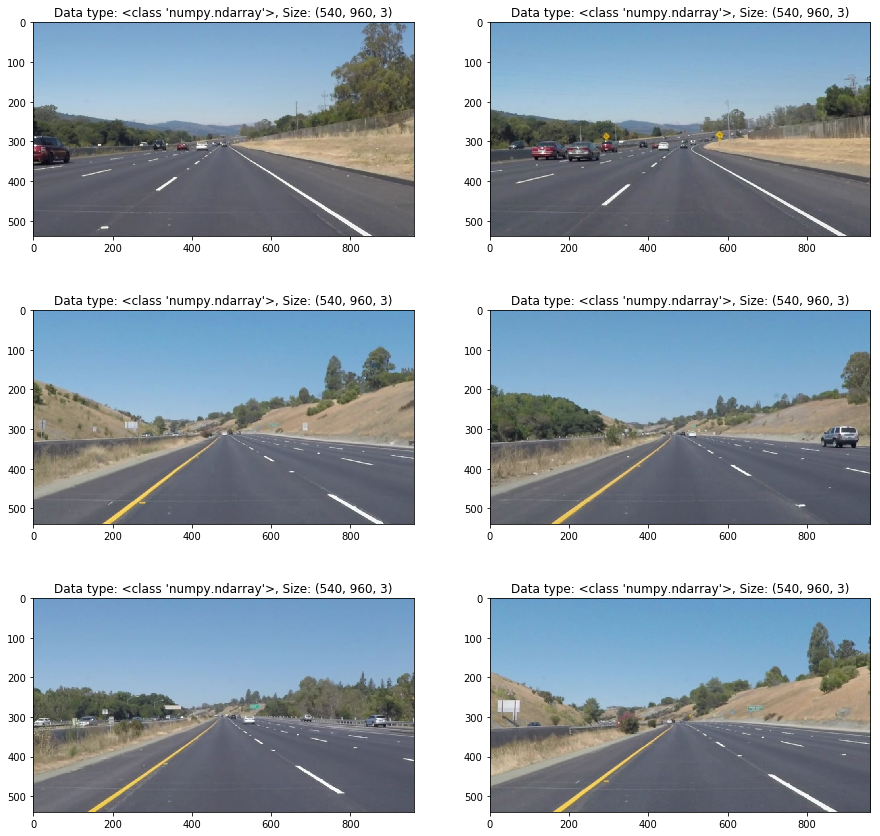

In [85]:
#reading paths of all test images
test_path_all_images = get_paths_of_all_test_images()

plt.figure(figsize=(15,15))
for i, path in enumerate(test_path_all_images):
    image = open_test_image(path)
    plt.subplot(3, 2, i+1).set_title("Data type: {}, Size: {}".format(type(image), image.shape))
    plt.imshow(image)
plt.show()

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [86]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an an array of lines coordinates.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

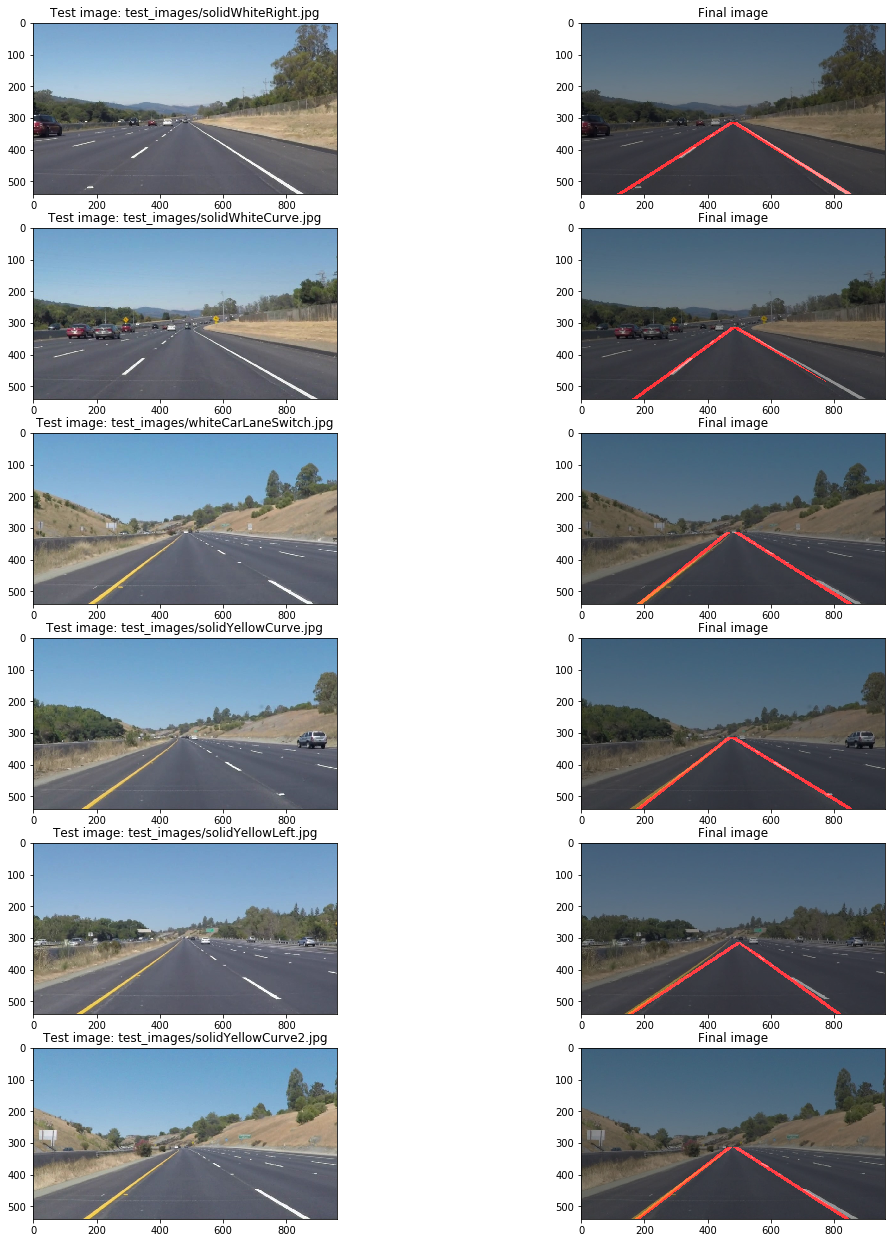

In [98]:
class Line:
    """
    Helper class representing line
    """
    def __init__(self, x1, y1, x2, y2):
        self.x1 = np.float32(x1)
        self.y1 = np.float32(y1)
        self.x2 = np.float32(x2)
        self.y2 = np.float32(y2)
        self.slope = self.compute_slope()
        self.slope_degrees = np.degrees(np.arctan(self.slope))
        self.intercept = self.compute_intercept() # intercept, the point where the line crosses the y-axis.

    def compute_slope(self):
        "m = (y2-y1)/(x2-x1)"
        m = (self.y2 - self.y1) / (self.x2 - self.x1)
        return m
    
    def compute_intercept(self):
        "b = y-mx"
        b = self.y1 - self.slope * self.x1
        return b
    
    def draw(self, image, color=[255,0,0], thickness=10):
        cv2.line(image, (self.x1, self.y1), (self.x2, self.y2), color, thickness)
        
    def __str__(self):
        return "x1:{}, y1:{}, x2:{}, y2:{}, --> slope:{}, slope_degrees:{}, intercept:{}" \
                .format(self.x1, self.y1, self.x2, self.y2, self.slope, self.slope_degrees, self.intercept)

        
def create_roi(image):
    # Define empty mask
    mask = np.zeros_like(image)
    # Do not touch white color
    ignore_mask_color = 255
    
    # Define a polygon to mask
    #    -
    #   / \
    #  /   \
    # /     \ 
    imshape = image.shape
    # imshape[0] - height
    # imshape[1] - width
    bottom_left  = (100,imshape[0])
    top_left     = (imshape[1]/2-20,imshape[0]/2+42)
    top_right    = (imshape[1]/2+20,imshape[0]/2+42)
    bottom_right = (imshape[1]-100,imshape[0])
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return mask


def extract_lanes(lines, image):
    """
    :param lines: lines from hough transform
    :param image:   image on which hough transform has been applied
    :return lanes: approx of where lines are located on the road
    """
    # Convert (x1, y1, x2, y2) tuples into Lines
    lines = [Line(l[0][0], l[0][1], l[0][2], l[0][3]) for l in lines]
    
    ########################################################################################

    
    # Extract right and left lane based on their slope
    left_lines  = [l for l in lines if (l.slope_degrees < -30 and l.slope_degrees > -60)]
    right_lines = [l for l in lines if (l.slope_degrees >  30 and l.slope_degrees <  60)]

    #     print("LEFT_LINES*********************")
    #     for i,l in enumerate(left_lines):
    #         l.draw(image, color=[255-i*6,0,0])
    #     plt.imshow(image, cmap='inferno')
    #     for l in left_lines:
    #         print(l)

    #     print("RIGHT_LINES*********************")
    #     for i,l in enumerate(right_lines):
    #         l.draw(image, color=[255-i*6,0,0])
    #     plt.imshow(image, cmap='inferno')
    #     for l in right_lines:
    #         print(l)
    
    # Interpolate intercepts and slopes to compute equation of line that approximates left lane
    lane_left_intercept = np.median([l.intercept for l in left_lines])
    lane_left_slope     = np.median([l.slope for l in left_lines])
    x1, y1 = 0, np.int32(lane_left_intercept)
    x2, y2 = -np.int32(np.round(lane_left_intercept / lane_left_slope)), 0
    left_lane = Line(x1, y1, x2, y2)

    # Interpolate intercepts and slopes to compute equation of line that approximates right lane
    lane_right_intercept = np.median([l.intercept for l in right_lines])
    lane_right_slope     = np.median([l.slope for l in right_lines])
    x1, y1 = 0, np.int32(lane_right_intercept)
    x2, y2 = np.int32(np.round((image.shape[0] - lane_right_intercept) / lane_right_slope)), image.shape[0]
    right_lane = Line(x1, y1, x2, y2)
    
    return left_lane, right_lane
    

def line_detection_process_image(img):
    # Read img and convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian Blur filter smoothing on grey image
    kernel_size = 5
    blur = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Apply Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur, low_threshold, high_threshold)
    
    # Create a roi where lines are expected
    roi = create_roi(edges)
    
    # Mask edges with the roi
    masked_edges_img = cv2.bitwise_and(edges, roi)
    
    # Extract lines
    rho = 2             # distance resolution in pixels of the Hough grid
    theta = (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 1      # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15   # minimum number of pixels making up a line
    max_line_gap = 5   # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges_img, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Get approx position of the lines on the road
    lane_lines = extract_lanes(lines, masked_edges_img)

    # Create a blank image to draw lines on
    lanes_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Draw lanes found
    for lane in lane_lines:
        lane.draw(lanes_image)
        
    # Mask lanes on the roi
    masked_lanes_img = cv2.bitwise_and(lanes_image, create_roi(lanes_image))

    final_img = weighted_img(masked_lanes_img, img, α=0.6, β=1., γ=0.)

    if DEBUG == 0:
        SAVE_IMGS = 1
        cols = 10
        rows = 1
        plt.figure(figsize=(50,70))
        plt.subplot(cols, rows, 1).set_title("input_image, {}".format(img.shape))
        plt.imshow(img)
        plt.subplot(cols, rows, 2).set_title("gray, {}".format(gray.shape))
        plt.imshow(gray, cmap='gray')
        plt.subplot(cols, rows, 3).set_title("blur, {}".format(blur.shape))
        plt.imshow(blur, cmap='gray')        
        plt.subplot(cols, rows, 4).set_title("edges, {}".format(edges.shape))
        plt.imshow(edges, cmap='gray')
        plt.subplot(cols, rows, 5).set_title("roi, {}".format(roi.shape))
        plt.imshow(roi, cmap='gray')
        plt.subplot(cols, rows, 6).set_title("masked_edges, {}".format(masked_edges_img.shape))
        plt.imshow(masked_edges_img, cmap='Greys_r')
        for lane in lane_lines:
            print(lane)
        plt.subplot(cols, rows, 7).set_title("lanes_image, {}\n LEFT_LANE:{}\n RIGHT_LANE:{}".format(lanes_image.shape, lane_lines[0], lane_lines[1]))
        plt.imshow(lanes_image)
        plt.subplot(cols, rows, 8).set_title("masked_lanes_img, {}".format(masked_lanes_img.shape))
        plt.imshow(masked_lanes_img)
        plt.subplot(cols, rows, 9).set_title("final_img, {}".format(final_img.shape))
        plt.imshow(final_img)     
        plt.show()
        if SAVE_IMGS == 1:
            # Save images
            save_pipeline_step_image("input_image.jpg", img)
            save_pipeline_step_image("gray.jpg", gray)
            save_pipeline_step_image("blur.jpg", blur)
            save_pipeline_step_image("edges.jpg", edges)
            save_pipeline_step_image("roi.jpg", roi)
            save_pipeline_step_image("masked_edges.jpg", masked_edges_img)
            save_pipeline_step_image("lanes_image.jpg", lanes_image)
            save_pipeline_step_image("masked_lanes_img.jpg", masked_lanes_img)
            save_pipeline_step_image("final_img.jpg", final_img)
    return img,final_img

# Go through all the images
plt.figure(figsize=(18,22))
for i in range(1, len(test_path_all_images)*2, 2):
    path = test_path_all_images[i//2]
    img,final_img = line_detection_process_image(open_test_image(path))
    plt.subplot(6, 2, i).set_title("Test image: "+path)
    plt.imshow(img)
    i = i+1
    plt.subplot(6, 2, i).set_title("Final image")
    plt.imshow(final_img)
    save_test_image_output(os.path.basename(path), final_img)

# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [88]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [89]:
def process_image(image):
    img, final_img = line_detection_process_image(image)
    return final_img

Let's try the one with the solid white lane on the right first ...

In [90]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4





  0%|          | 0/222 [00:00<?, ?it/s]


  5%|▍         | 11/222 [00:00<00:01, 109.78it/s]


 10%|▉         | 22/222 [00:00<00:01, 108.95it/s]


 15%|█▍        | 33/222 [00:00<00:01, 109.21it/s]


 20%|█▉        | 44/222 [00:00<00:01, 108.97it/s]


 24%|██▍       | 53/222 [00:00<00:01, 91.07it/s] 


 28%|██▊       | 62/222 [00:00<00:01, 88.86it/s]


 32%|███▏      | 70/222 [00:00<00:01, 85.68it/s]


 36%|███▌      | 79/222 [00:00<00:01, 86.79it/s]


 40%|███▉      | 88/222 [00:00<00:01, 86.61it/s]


 44%|████▎     | 97/222 [00:01<00:01, 85.54it/s]


 48%|████▊     | 107/222 [00:01<00:01, 87.95it/s]


 52%|█████▏    | 116/222 [00:01<00:01, 85.92it/s]


 56%|█████▋    | 125/222 [00:01<00:01, 82.08it/s]


 60%|██████    | 134/222 [00:01<00:01, 83.70it/s]


 64%|██████▍   | 143/222 [00:01<00:00, 83.40it/s]


 68%|██████▊   | 152/222 [00:01<00:00, 84.99it/s]


 73%|███████▎  | 162/222 [00:01<00:00, 86.16it/s]


 77%|███████▋  | 171/222 [00:01<00:00, 86.78it/s]


 81%|████████  | 180/222

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.82 s, sys: 324 ms, total: 3.14 s
Wall time: 2.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [92]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  2%|▏         | 11/682 [00:00<00:06, 107.84it/s]


  3%|▎         | 23/682 [00:00<00:05, 110.32it/s]


  5%|▌         | 35/682 [00:00<00:05, 112.42it/s]


  7%|▋         | 46/682 [00:00<00:05, 111.58it/s]


  8%|▊         | 55/682 [00:00<00:06, 92.45it/s] 


  9%|▉         | 63/682 [00:00<00:07, 85.68it/s]


 11%|█         | 72/682 [00:00<00:07, 85.63it/s]


 12%|█▏        | 81/682 [00:00<00:06, 86.42it/s]


 13%|█▎        | 91/682 [00:00<00:06, 88.07it/s]


 15%|█▍        | 100/682 [00:01<00:06, 85.94it/s]


 16%|█▌        | 109/682 [00:01<00:06, 87.08it/s]


 17%|█▋        | 118/682 [00:01<00:06, 83.89it/s]


 19%|█▊        | 127/682 [00:01<00:06, 84.17it/s]


 20%|█▉        | 136/682 [00:01<00:06, 80.66it/s]


 21%|██▏       | 145/682 [00:01<00:06, 81.50it/s]


 23%|██▎       | 154/682 [00:01<00:06, 80.81it/s]


 24%|██▍       | 163/682 [00:01<00:06, 81.83it/s]


 25%|██▌       | 172/682 [00:01<00:06, 82.79it/s]


 27%|██▋       | 181/68

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.99 s, sys: 987 ms, total: 9.98 s
Wall time: 8.32 s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [94]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4





  0%|          | 0/251 [00:00<?, ?it/s]


  3%|▎         | 7/251 [00:00<00:03, 69.33it/s]


  6%|▌         | 14/251 [00:00<00:03, 68.61it/s]


  8%|▊         | 21/251 [00:00<00:03, 67.97it/s]


 11%|█         | 28/251 [00:00<00:03, 66.25it/s]


 14%|█▍        | 36/251 [00:00<00:03, 67.46it/s]


 17%|█▋        | 43/251 [00:00<00:03, 66.80it/s]


 20%|█▉        | 49/251 [00:00<00:03, 50.78it/s]


 22%|██▏       | 55/251 [00:00<00:03, 52.57it/s]


 24%|██▍       | 61/251 [00:01<00:03, 49.99it/s]


 27%|██▋       | 67/251 [00:01<00:03, 46.53it/s]


 29%|██▊       | 72/251 [00:01<00:03, 46.89it/s]


 31%|███       | 77/251 [00:01<00:03, 47.08it/s]


 33%|███▎      | 82/251 [00:01<00:03, 47.10it/s]


 35%|███▍      | 87/251 [00:01<00:03, 47.67it/s]


 37%|███▋      | 92/251 [00:01<00:03, 46.87it/s]


 39%|███▊      | 97/251 [00:01<00:03, 46.76it/s]


 41%|████      | 102/251 [00:01<00:03, 45.85it/s]


 43%|████▎     | 107/251 [00:02<00:03, 46.96it/s]


 45%|████▍     | 112/251 [00:02<00:0

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.84 s, sys: 623 ms, total: 6.47 s
Wall time: 6.02 s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Writeup and Submission
For wrtiteup and summary go to [Writeup](writeup.md)